# How good are language models we use for Style Transfer?

Let's load pretrained language models on sentiment data. We will test both yelp and sentiment treebank language models. 

In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn as nn
from tqdm.auto import tqdm

plt.style.use('fivethirtyeight')

In [3]:
from style_transfer import Tokenizer, get_dataset, translate
sys.path.append('../deep-latent-sequence-model/src')
from lm_lstm import LSTM_LM

device = torch.device('cpu')
model_dir = '../deep-latent-sequence-model/pretrained_lm/sentiment_style0'
model_path = os.path.join(model_dir, 'model.pt')
model = torch.load(model_path).eval().to(device)

vocab_path = 'data/sentiment/text.vocab'
with open(vocab_path) as f:
    vocab = [word.strip() for word in f.readlines()]
tokenizer = Tokenizer(vocab)

In [4]:
model

LSTM_LM(
  (embed): Embedding(11330, 64, padding_idx=0)
  (dropout_in): Dropout(p=0.3, inplace=False)
  (dropout_out): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(64, 256, batch_first=True)
  (pred_linear): Linear(in_features=256, out_features=11330, bias=True)
  (loss): CrossEntropyLoss()
)

## Predicting next word given a sequence of words 

In [5]:
x = torch.tensor([[1, 2, 3]])
x_len = torch.tensor([3])
print(model.log_probability(x, x_len))
logits = model.decode(x, x_len)  # (batch_size, seq_len, vocab_size)
output_logits = logits[0, -1, :]
output_logits.shape

tensor([-18.9621], grad_fn=<NegBackward>)


torch.Size([11330])

In [6]:
predicted_words = output_logits.argmax()
predicted_words

tensor(6904, grad_fn=<NotImplemented>)

In [7]:
tokenizer.decode(6904)

'of'

## Deterministic sequence generation given initial word

In [8]:
tokenizer.tokenize('i')

[5022]

Single next word to see if this works.

In [9]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
x = torch.tensor([tokens])
x_len = [len(tokens)]
next_word_logits = model.decode(x, x_len)[0, -1, :]
predicted_token = next_word_logits.argmax().item()
predicted_token, tokenizer.decode(predicted_token)

(4088, 'food')

Generating sequence of words.

In [27]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
while words[-1] != '.':
    x = torch.tensor([tokens])
    x_len = [len(tokens)]
    next_word_logits = model.decode(x, x_len)[0, -1, :]
    predicted_token = next_word_logits.argmax().item()
    tokens.append(predicted_token)
    words.append(tokenizer.decode(predicted_token))
' '.join(words)

'The food is great .'

In [28]:
def generate_sequence_from(words):
    tokens = [tokenizer.tokenize(word)[0] for word in words]
    while words[-1] != '.':
        x = torch.tensor([tokens])
        x_len = [len(tokens)]
        next_word_logits = model.decode(x, x_len)[0, -1, :]
        predicted_token = next_word_logits.argmax().item()
        tokens.append(predicted_token)
        words.append(tokenizer.decode(predicted_token))
    return ' '.join(words)

In [29]:
print(generate_sequence_from(["The"]))
print(generate_sequence_from(["The place"]))
print(generate_sequence_from(["I"]))
print(generate_sequence_from(["We"]))
print(generate_sequence_from(["What"]))
print(generate_sequence_from(["Well"]))
print(generate_sequence_from(["Do"]))
print(generate_sequence_from(["Hmm"]))
print(generate_sequence_from(["Possibly"]))
print(generate_sequence_from(["Not"]))
print(generate_sequence_from(["I would"]))
print(generate_sequence_from(["The restaurant"]))

The food is great .
The place food is great .
I was in the area .
We had a great time .
What a great experience .
Well .
Do n't go here .
Hmm .
Possibly the best .
Not .
I would was in the area .
The restaurant food is great .


The language model we trained is not of the best quality unfortunately. If language model doesn't work well, we can't really expect final style transfer model to work well, since it is a prior in our model.

In [30]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Random sampling of words with logits probability

In [31]:
words = ["The"]
tokens = [tokenizer.tokenize(word)[0] for word in words]
x = torch.tensor([tokens])
x_len = [len(tokens)]
next_word_logits = model.decode(x, x_len)[0, -1, :]
predicted_token = random.choices(np.arange(len(next_word_logits)), weights=next_word_logits.softmax(0))[0]
predicted_token, tokenizer.decode(predicted_token)

(4088, 'food')

The most probable words after 'the'.

In [32]:
def most_probable(next_word_logits, k=10):
    word_probs = list(zip(vocab, next_word_logits.softmax(0).detach().numpy()))
    return sorted(word_probs, key=lambda t: t[1], reverse=True)[:k]
most_probable(next_word_logits, k=15)

[('food', 0.0798661),
 ('best', 0.048512522),
 ('service', 0.042795498),
 ('place', 0.034777235),
 ('staff', 0.022928242),
 ('whole', 0.014919265),
 ('other', 0.011666374),
 ('price', 0.011257088),
 ('worst', 0.011031059),
 ('first', 0.009258132),
 ('restaurant', 0.009205581),
 ('next', 0.007650043),
 ('same', 0.0071197585),
 ('entire', 0.007114196),
 ('store', 0.007070742)]

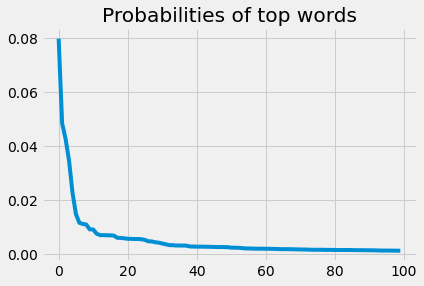

In [33]:
probs = next_word_logits.softmax(0).detach().numpy()
sorted_word_probs = sorted(probs, reverse=True)
plt.plot(sorted_word_probs[:100])
plt.title('Probabilities of top words');

In [36]:
tokenizer.tokenize('<pad>')

[1]

In [39]:
tokenizer.decode(0), tokenizer.decode(1)

('!', '#')

I just realized, that in my vocab I forgot to put \<pad\> and \<unk\> tokens!

In [44]:
def generate_random_sequence_from(words):
    tokens = [tokenizer.tokenize(word)[0] for word in words]
    while words[-1] != '.' and words[-1] != '<pad>':
        x = torch.tensor([tokens])
        x_len = [len(tokens)]
        next_word_logits = model.decode(x, x_len)[0, -1, :]
        predicted_token = random.choices(np.arange(len(next_word_logits)), weights=next_word_logits.softmax(0))[0]
        tokens.append(predicted_token)
        words.append(tokenizer.decode(predicted_token))
    return ' '.join(words)
generate_random_sequence_from(["The"])

'The record shop some what you get .'